# Download Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# create directory for kaggle json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# dowload dataset
!kaggle datasets download -d deadskull7/fer2013

 97% 94.0M/96.6M [00:00<00:00, 131MB/s]
100% 96.6M/96.6M [00:00<00:00, 142MB/s]


In [4]:
# unzip dataset
import zipfile
zip_ref = zipfile.ZipFile('fer2013.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

# Import Libraries

In [5]:
# Import libraries
import csv
import os
import pickle
import warnings
warnings.filterwarnings('ignore')
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
from collections import defaultdict
from numpy.random import seed
seed(1)
%matplotlib inline

# EDA

In [6]:
# dataset
data_path = '/content/files/fer2013.csv'

In [7]:
data = pd.read_csv(data_path)
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
data['emotion'].value_counts(normalize=True)

3    0.250481
6    0.172709
4    0.169337
2    0.142698
0    0.138017
5    0.111517
1    0.015242
Name: emotion, dtype: float64

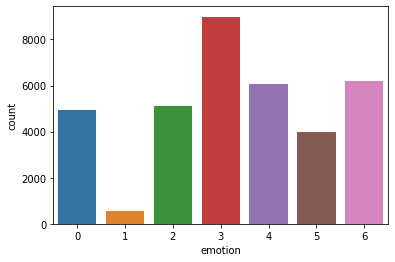

In [9]:
sns.countplot(data['emotion'])

# Dataset Class

In [10]:
class FacialEmotionDataset(Dataset):
    
    def __init__(self, images=None, emotions=None, transform=None):
        self.images = images
        self.emotions = emotions
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        emotion = self.emotions[index]
        
        if self.transform is not None:
            image = self.transform(image)
        return image, emotion
    

class DatasetFactory:
    
    def __init__(self):
        self.images = []
        self.emotions = []
        self.val_images = []
        self.val_emotions = []
        self.test_images = []
        self.test_emotions = []
        
        with open(data_path, 'r') as file:
            data = csv.reader(file)
            next(data)
            for row in data:
                face = [int(pixel) for pixel in row[1].split()]
                face = np.asarray(face).reshape(48, 48)
                face = face.astype(np.uint8)
                
                if row[-1] == 'Training':
                    self.images.append(Image.fromarray(face))
                    self.emotions.append(int(row[0]))
                
                if row[-1] == 'PrivateTest':
                    self.val_images.append(Image.fromarray(face))
                    self.val_emotions.append(int(row[0]))
                    
                if row[-1] == 'PublicTest':
                    self.test_images.append(Image.fromarray(face))
                    self.test_emotions.append(int(row[0]))
                
        print(f'Training size: {len(self.images)}, \nTest size: {len(self.test_images)},\nValidation size: {len(self.val_images)}')

# Augumentation

In [11]:
new_size = (224, 224)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Resize(new_size),
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                transforms.Normalize(mean, std)
                                ])
 
val_transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize(new_size),
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                transforms.Normalize(mean, std)
                                ])

# Load Dataset

In [12]:
factory = DatasetFactory() 

training = FacialEmotionDataset(factory.images, factory.emotions, train_transform)
validation = FacialEmotionDataset(factory.val_images, factory.val_emotions, val_transform)
testing = FacialEmotionDataset(factory.test_images, factory.test_emotions, val_transform)

Training size: 28709, 
Test size: 3589,
Validation size: 3589


# DataLoader

In [13]:
train_loader = DataLoader(training, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation, batch_size=64, shuffle=True)
testing_loader = DataLoader(testing, batch_size=32)

# Data Viz.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape:  torch.Size([64, 3, 224, 224])


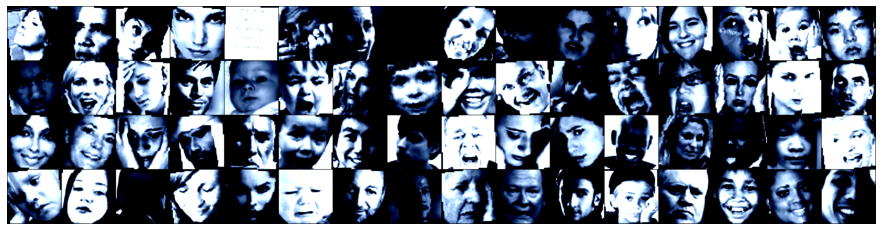

In [14]:
for images, labels in train_loader:
    print('images.shape: ', images.shape)
    plt.figure(figsize=(16, 4))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [29]:
def train(model, optimizer, criterion, data_loader): #scheduler
  running_correct = 0.0
  running_loss = 0.0

  for data, label in data_loader:
    torch.cuda.empty_cache()
    if torch.cuda.is_available():
      data, label = data.cuda(), label.cuda()
    
    optimizer.zero_grad()
    model = model.train()
    output = model(data)
    loss = criterion(output, label)
    preds = output.data.max(dim=1, keepdim=True)[1]
    running_correct += preds.eq(label.data.view_as(preds)).cpu().sum()
    running_loss += criterion(output, label).item()

    loss.backward()
    optimizer.step()
    # scheduler.step()

    loss = running_loss / len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)

  print(f'training loss is {loss:{5}.{2}} and training accuracy is \
  {running_correct}/({len(data_loader.dataset)}{accuracy:{10}.{4}}')
  return loss, accuracy


def validate(model, criterion, data_loader):
  running_correct = 0.0
  running_loss = 0.0

  with torch.no_grad():
    for data, label in data_loader:
      torch.cuda.empty_cache()
      if torch.cuda.is_available():
        data, label = data.cuda(), label.cuda()
      model = model.eval()
      output = model(data)
      loss = criterion(output, label)
      preds = output.data.max(dim=1, keepdim=True)[1]
      running_correct += preds.eq(label.data.view_as(preds)).cpu().sum()
      running_loss += criterion(output, label).item()

    loss = running_loss / len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)

  print(f'validation loss is {loss:{5}.{2}} and validation accuracy is \
  {running_correct}/({len(data_loader.dataset)}{accuracy:{10}.{4}}')
  return loss, accuracy

# Model

In [14]:
resnet = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [15]:
# move resnet to gpu
torch.cuda.empty_cache()
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
resnt = resnet.to(device)

In [16]:
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 7)
resnet.fc = resnet.fc.to(device)

# Finetune Resnet

In [17]:
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001, momentum=0.5)
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 6
history = defaultdict(list)
for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch+1}/{epochs}')
    train_loss, train_accuracy = train(resnet, optimizer, criterion, train_loader)
    val_loss, val_accuracy = validate(resnet, criterion, validation_loader)
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)
    history["val_accuracy"].append(val_accuracy)
    history["val_loss"].append(val_loss)

In [18]:
def test_accuracy(model, criterion, data_loader):
  test_preds = []
  test_labels = []

  running_correct = 0.0
  running_loss = 0.0

  with torch.no_grad():
    for data, labels in data_loader:
      torch.cuda.empty_cache()
      model = model.eval()
      data, labels = data.to(device), labels.to(device)
      outputs = model(data)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, dim=1)
      
      test_preds.append(preds.cpu().numpy())
      test_labels.append(labels.cpu().numpy())

      running_correct += torch.sum(preds == labels)
      running_loss += loss.item()

    loss = running_loss / len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)

  print(f'validation loss is {loss:{5}.{2}} and validation accuracy is \
  {running_correct}/({len(data_loader.dataset)}{accuracy:{10}.{4}}')
  
  test_preds = np.concatenate(np.array(test_preds))
  test_labels = np.concatenate(np.array(test_labels))

  return test_preds, test_labels

In [30]:
preds, targets = test_accuracy(resnet, criterion, testing_loader)

validation loss is 0.033 and validation accuracy is   2168.0/(3589     60.41


In [ ]:
targets = y_dev
predictions = pca_pred
df = pd.DataFrame({"targets":targets,"predictions":predictions})
df["targets"] = df["targets"].map(target_map)
df["predictions"] = df["predictions"].map(target_map)
df = pd.crosstab(df["targets"],df["predictions"])
plt.figure(figsize=(10,6))
sns.heatmap(df , cmap="Blues",annot=True,fmt=".2f")
plt.title("Test Confusion Marix")
# plt.savefig("Test Confusion Marix")

# Data Upsampling

In [19]:
from sklearn.utils import resample

In [20]:
df_minority = data[data['emotion']==1]
df_majority = data[data['emotion']!=1]

df_minority_upsampled = resample(df_minority,
                              replace=True,
                              n_samples=3000,
                              random_state=42)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [21]:
df_upsampled.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


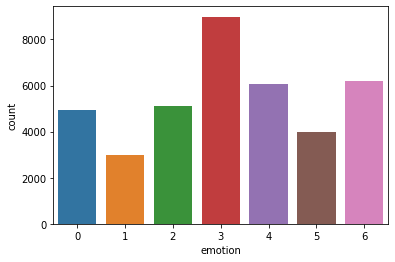

In [22]:
sns.countplot(df_upsampled['emotion'])

In [23]:
df_upsampled.to_csv('Balanced_data.csv', index=False)

In [24]:
class DatasetFactory:
    
    def __init__(self):
        self.images = []
        self.emotions = []
        self.val_images = []
        self.val_emotions = []
        self.test_images = []
        self.test_emotions = []
        
        with open('/content/Balanced_data.csv', 'r') as file:
            data = csv.reader(file)
            next(data)
            for row in data:
                face = [int(pixel) for pixel in row[1].split()]
                face = np.asarray(face).reshape(48, 48)
                face = face.astype(np.uint8)
                
                if row[-1] == 'Training':
                    self.images.append(Image.fromarray(face))
                    self.emotions.append(int(row[0]))
                
                if row[-1] == 'PrivateTest':
                    self.val_images.append(Image.fromarray(face))
                    self.val_emotions.append(int(row[0]))
                    
                if row[-1] == 'PublicTest':
                    self.test_images.append(Image.fromarray(face))
                    self.test_emotions.append(int(row[0]))
                
        print(f'Training size: {len(self.images)}, \nTest size: {len(self.test_images)},\nValidation size: {len(self.val_images)}')

# Load Upsampled Dataset

In [25]:
factory = DatasetFactory() 

training = FacialEmotionDataset(factory.images, factory.emotions, train_transform)
validation = FacialEmotionDataset(factory.val_images, factory.val_emotions, val_transform)
testing = FacialEmotionDataset(factory.test_images, factory.test_emotions, val_transform)

Training size: 30671, 
Test size: 3836,
Validation size: 3833


In [26]:
train_loader = DataLoader(training, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation, batch_size=64, shuffle=True)
testing_loader = DataLoader(testing, batch_size=32)

# Train

In [41]:
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

In [42]:
epochs = 3
history = defaultdict(list)
for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch+1}/{epochs}')
    train_loss, train_accuracy = train(resnet, optimizer, criterion, train_loader)
    val_loss, val_accuracy = validate(resnet, criterion, validation_loader)
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)
    history["val_accuracy"].append(val_accuracy)
    history["val_loss"].append(val_loss)

Epoch 1/3
training loss is 0.021 and training accuracy is   15280.0/(30671     49.82
validation loss is 0.018 and validation accuracy is   2172.0/(3833     56.67
Epoch 2/3
training loss is 0.016 and training accuracy is   19183.0/(30671     62.54
validation loss is 0.016 and validation accuracy is   2387.0/(3833     62.27
Epoch 3/3
training loss is 0.014 and training accuracy is   20404.0/(30671     66.53
validation loss is 0.016 and validation accuracy is   2437.0/(3833     63.58



In [43]:
epochs = 4
# history = defaultdict(list)
for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch+1}/{epochs}')
    train_loss, train_accuracy = train(resnet, optimizer, criterion, train_loader)
    val_loss, val_accuracy = validate(resnet, criterion, validation_loader)
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)
    history["val_accuracy"].append(val_accuracy)
    history["val_loss"].append(val_loss)

Epoch 1/4
training loss is 0.013 and training accuracy is   21380.0/(30671     69.71
validation loss is 0.015 and validation accuracy is   2514.0/(3833     65.59
Epoch 2/4
training loss is 0.012 and training accuracy is   22071.0/(30671     71.96
validation loss is 0.015 and validation accuracy is   2535.0/(3833     66.14
Epoch 3/4
training loss is 0.011 and training accuracy is   22644.0/(30671     73.83
validation loss is 0.015 and validation accuracy is   2550.0/(3833     66.53
Epoch 4/4
training loss is  0.01 and training accuracy is   23277.0/(30671     75.89
validation loss is 0.016 and validation accuracy is   2512.0/(3833     65.54



# Feature Extraction

In [44]:
torch.cuda.empty_cache()
resnet = torchvision.models.resnet18(pretrained=True)

# move resnet to gpu
torch.cuda.empty_cache()
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')

resnet = resnet.to(device)

In [ ]:
for param in resnet.parameters.fe